In [1]:
#@title Import e funzioni utili
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from scipy.optimize import curve_fit
import scipy.stats
import sys
sys.path.append("../main/")
from santa_fe_4 import *

@njit()
def compute_signature_plot(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        new_arr = array[::i]
        square_sum = (new_arr[1:] - new_arr[:-1])**2
        sigma[i-1] = square_sum.sum()
    
    return np.sqrt(sigma)

def linear(x, m, q):
    return m * x + q

def find_param(xx,yy):
    popt, pcov = curve_fit(linear, xx, yy)
    m = popt[0]
    q = popt[1]
    err_m = np.sqrt(pcov[0][0])
    err_q = np.sqrt(pcov[1][1])

    
    return m, q, err_m, err_q
plt.style.use('dark_background')

# Data cleaning

Per prima cosa ho riunito tutti i files corrispondenti allo stato del LOB nel mese di ottobre in un unico dataframe e successivamente ho iniziato il processo di data cleaning.

In [2]:
#create a list of all the files in the folder
DIR = "../data/energia/LOB_ottobre21/LOB_ottobre21/"
lob_files =os.listdir(DIR)
lob_files.sort()
lst_order = []
# for each files in the folder
for element in lob_files:
    # import data
    df = pd.read_csv(DIR+ element)
    # delete first two column and empty LOB
    df.drop(columns = ["Unnamed: 0", "key"], inplace = True)
    # Add mid price and spread
    df["MidPrice"] = (df["BidPrice_0"] + df["AskPrice_0"]) / 2
    df["Spread"] = df["AskPrice_0"] - df["BidPrice_0"]
    lst_order.append(df)

# concatenate the daily data into an unique dataframe
raw_data = pd.concat(lst_order)
raw_data.reset_index(inplace = True, drop = True)
raw_data.head()

,Datetime,BidPrice_0,BidVolume_0,AskPrice_0,AskVolume_0,BidPrice_1,BidVolume_1,AskPrice_1,AskVolume_1,BidPrice_2,...,BidPrice_8,BidVolume_8,AskPrice_8,AskVolume_8,BidPrice_9,BidVolume_9,AskPrice_9,AskVolume_9,MidPrice,Spread
0,2021-10-01 05:30:03.561000,108.5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-01 06:00:01.630000,108.5,1.0,140.0,1.0,52.0,1.0,NaN,NaN,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.25,31.5
2,2021-10-01 06:00:19.222000,108.5,1.0,140.0,1.0,93.8,1.0,NaN,NaN,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.25,31.5
3,2021-10-01 06:02:37.526000,130.0,1.0,140.0,1.0,108.5,1.0,NaN,NaN,93.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.00,10.0
4,2021-10-01 06:03:29.627000,130.0,1.0,140.0,2.0,108.5,1.0,NaN,NaN,93.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.00,10.0


Uniti i files possiamo vedere che il dataframe ha 43 colonne differenti. 

La prima colonna rappresenta la data in cui è stata effettuato un ordine, le altre rappresentano il prezzo e il volume delle 10 migliori quote del bid price e dell'ask price e le ultime due che ho aggiunto io rappresentano il mid price e lo spread.

Per prima cosa ho notato che, a differenza dei dati relativi a Tesla, il LOB è sparso e in molti casi non sono presenti ordini nell'ask o nel bid.

Ho quindi fatto un grafico a barre in scala logaritmica, del numero di volte in cui non sono presenti ordini per le 10 migliori quote dell'ask e del bid.

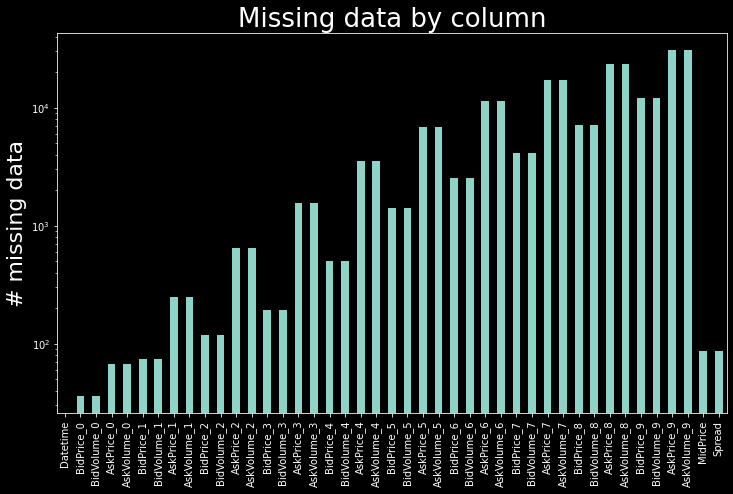

In [3]:
fig,ax = plt.subplots(1,1,figsize = (12,7))
raw_data.isnull().sum().plot.bar()
plt.yscale("log")
plt.ylabel("# missing data", fontsize = 22)
plt.title("Missing data by column", fontsize = 26)
plt.show()

Per evitare discontinuità enormi dello spread e mid price, ho deciso di eliminare dal dataframe le righe in cui il miglior ask oppure il miglior bid erano uguali a 0.

Un'altra cosa che ho notato è che in certi momenti lo spread risulta uguale a zero oppure negativo.

In [4]:
raw_data.fillna(0, inplace = True)
zero_sp = len(raw_data[raw_data["Spread"] == 0])
negative_sp = len(raw_data[raw_data["Spread"] < 0])
print(f"Number of istances with spread = 0 : {zero_sp}")
print(f"Number of istances with spread < 0 : {negative_sp}")

Number of istances with spread = 0 : 7479
Number of istances with spread < 0 : 10281


Sicuramente questo è stato causato da un errore nel trascrivere i dati, perciò  ho deciso di eliminare dal dataframe le righe aventi spread <=0.

Una volta fatto ciò, risulta che per il giorno 27/10/2021 le righe aventi spread > 0 sono solamente 25.

In [5]:
#raw_data = raw_data[raw_data["Spread"] > 0]

a = lst_order[18]
n_trades = len(a[a["Spread"] > 0])
print(f"27/10: Trades with spread > 0 = {n_trades}")

27/10: Trades with spread > 0 = 25


Per questo motivo ho deciso di eliminare dal dataframe tutti i trades effettuati nel giorno 27/10. 

Successivament ho graficato la funzione CDF della lunghezza dei periodi con spread <= 0

In [6]:
# Find time with spread <= 0
# from string to datetime
raw_data["Datetime"]= pd.to_datetime(raw_data["Datetime"])
# add seconds to midnight
seconds = np.zeros(len(raw_data))
for i, date in enumerate(raw_data["Datetime"]):
    seconds[i] =  date.second + 60 * date.minute + 3600 * date.hour + \
                    date.microsecond * 1e-6 + date.day * 3600 * 24

raw_data["Time"] = seconds
# save all the index in which the spread is <= 0
lst_spread = raw_data.loc[raw_data["Datetime"].dt.day != 27].loc[raw_data["Spread"] <= 0].index.to_list()

nn = []
i = 1
while i < len(lst_spread):
  temp = [lst_spread[i-1]]
  while lst_spread[i] == lst_spread[i-1] + 1 and i < len(lst_spread) - 1:
   temp.append(lst_spread[i])
   i += 1
  temp.append(lst_spread[i-1] +1)
  nn.append(temp)
  i += 1

negative_time = []
for element in nn:
  first = raw_data["Time"].at[element[0]]
  last = raw_data["Time"].at[element[-1]]
  negative_time.append(last - first)

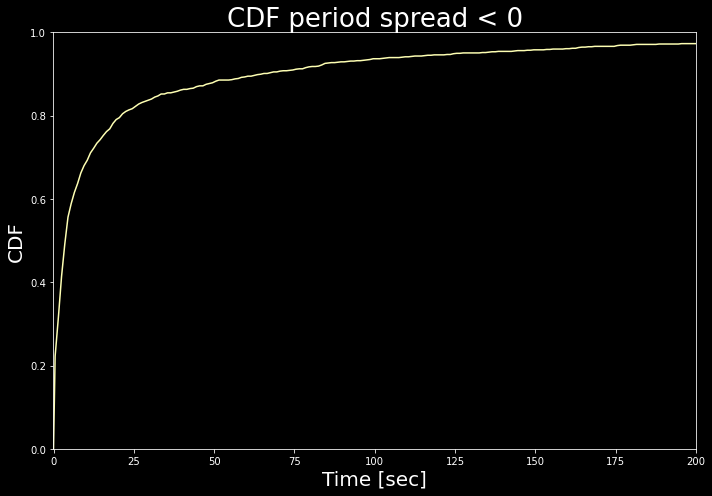

In [7]:
fig,ax = plt.subplots(1,1,figsize = (10,7), tight_layout = True)
plt.title("CDF period spread < 0", fontsize=26)
# create histogram
n, bb, _ = plt.hist(negative_time, bins = np.arange(0,5000,1), alpha=0)
# calculate the center of the bins 
new_bb = (bb[1:] +bb[:-1])/2
x = [0]
[x.append(i) for i in new_bb]
# compute cdf
y = [0]
[y.append(i) for i in n.cumsum()/n.sum()]

plt.plot(x, y)
plt.xlim(-.1,200)
plt.ylim(0,1)
plt.ylabel("CDF", fontsize=20)
plt.xlabel("Time [sec]", fontsize=20)
plt.savefig("../figures/CDF_spread.jpeg", dpi= 300)
plt.show()

Dalla figura si evince che il tempo in cui lo spread risulta <= 0 è relativamente basso.

In [8]:
temp = np.array(negative_time)
tot_len = len(temp)
# esclude times where the spread is <= for a lot of time
temp = temp[temp<1e4]

mean_t = temp.mean()
print(f"Mean duration of periods with spread <=0 : {mean_t:.0f} seconds")

temp1 = temp[temp < 100]
p_val = len(temp1) / tot_len 
print(f"\nProbability to have spread <= 0 for less than 100 sec :{p_val:.3f}")

temp = temp[temp < 10]
p_val = len(temp) / tot_len 
print(f"\nProbability to have spread <= 0 for less than 10 sec :{p_val:.3f}")

Mean duration of periods with spread <=0 : 43 seconds

Probability to have spread <= 0 for less than 100 sec :0.925

Probability to have spread <= 0 for less than 10 sec :0.671


# Volume scambiato

Quando ho analizzato i dati Tesla, ho eliminato la prima ora e l'ultima mezz'ora di tranding, in quanto ad inizio e a fine giornata il volume scambiato risulta molto più alto del normale. Vediamo se questo è valido anche nel caso dei dati energetici. 

In [58]:
#@title Clean data
lst_order = []

for element in lob_files:
    # import data
    df = pd.read_csv(DIR+ element)
    df.fillna(0, inplace = True)
    

    # delete first two column and empty LOB
    df.drop(columns = ["Unnamed: 0", "key"], inplace = True)
    df.drop(df[df["AskPrice_0"] == 0].index.to_list(), inplace = True)
    df.drop(df[df["BidPrice_0"] == 0].index.to_list(), inplace = True)

    # scale price to dollar cent and add mid price and spread
    df["BidPrice_0"] = df["BidPrice_0"]
    df["AskPrice_0"] = df["AskPrice_0"]
    df["MidPrice"] = (df["BidPrice_0"] + df["AskPrice_0"]) / 2
    df["Spread"] = df["AskPrice_0"] - df["BidPrice_0"]

    # transform the column Datetime from string to datetime
    df["Datetime"]= pd.to_datetime(df["Datetime"])

    #delete trades befor 6:00 and after 17:00 
    df = df[df["Datetime"].dt.hour > 5]
    df = df[df["Datetime"].dt.hour < 17]

    #create a new column that represent second to midnight 
    seconds = np.zeros(len(df))
    for i, date in enumerate(df["Datetime"]):
        seconds[i] = date.second + 60 * date.minute + 3600 * date.hour + \
                                    date.microsecond * 1e-6 + date.day * 3600 * 24
    df["Seconds"] = seconds

    #add a column that represent the absolute change in volume between two trades
    df["TotVolume"] = [1 for i in range(len(df))]

    #delete rows with spread <= 0
    #df = df[df["Spread"] > 0]
    
    lst_order.append(df)
    
clean_data = pd.concat(lst_order)
clean_data.reset_index(inplace = True, drop = True)
clean_data["Datetime"] = pd.to_datetime(clean_data["Datetime"])

Ho preso i dati relativi a tutto il mese di ottobre e ho fatto un grafico a barre della media del volume scambiato ad ogni ora.

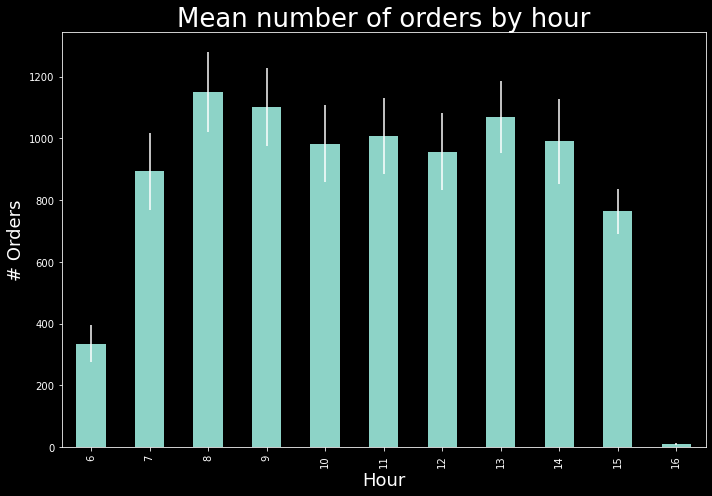

In [35]:
fig,ax = plt.subplots(1,1,figsize = (10,7), tight_layout=True)

gg = clean_data.groupby([clean_data["Datetime"].dt.day, clean_data["Datetime"].dt.hour])["TotVolume"].sum()
gg.groupby(level=1).mean().plot.bar(yerr = gg.groupby(level=1).std() / np.sqrt(gg.groupby(level=1).count()))

plt.title("Mean number of orders by hour", fontsize = 26)
plt.ylabel("# Orders", fontsize = 18)
plt.xlabel("Hour",fontsize = 18)
plt.savefig("../figures/orders_by_hour.jpeg", dpi = 300)
plt.show()

Si può osservare che per la prima e ultima ora di trading il volume scambiato è molto basso.

# Analisi dati con frequenza al secondo

Finito il processo di data cleaning ho campionato lo stato del LOB ogni secondo per visualizzare l'andamento del mid price, la distribuzione dello spread, la distribuzione del logaritmo dei ritorni e il signature plot.

Anche se il volume scambiato è basso ho deciso comunque di togliere la prima e ultima ora di trading.

In [36]:
#@title Importare dati al secondo
lst_time = []

for element in lob_files:
    # import data
    df = pd.read_csv(DIR+ element)
    df.fillna(0, inplace = True)
    # delete first two column and empty LOB
    df.drop(columns = ["Unnamed: 0", "key"], inplace = True)
    df.drop(df[df["AskPrice_0"] == 0].index.to_list(), inplace = True)
    df.drop(df[df["BidPrice_0"] == 0].index.to_list(), inplace = True)

    # add mid price and spread
    df["MidPrice"] = (df["BidPrice_0"] + df["AskPrice_0"]) / 2
    df["Spread"] = df["AskPrice_0"] - df["BidPrice_0"]

    # add new column that raprents seconds to midnight
    df["Datetime"]= pd.to_datetime(df["Datetime"])
    seconds = np.zeros(len(df))
    for i, date in enumerate(df["Datetime"]):
        seconds[i] = date.second + 60 * date.minute + 3600 * date.hour + \
                                    date.microsecond * 1e-6
    
    df["Time"] = seconds
    secs = []
    start = 21601
    # sample the LOB every second
    for i,element in enumerate(df["Time"]):           
        if start < element:
            while start < element:
                secs.append(i-1)
                start += 1

    # ignore the first hour and last 30 minutes of trading
    df = df.iloc[secs]
    
    #consider only data with spread > 0
    df = df[df["Spread"] > 0]
    
    #delete first and last hour of trading
    df = df.loc[df["Datetime"].dt.hour > 6]
    df = df.loc[df["Datetime"].dt.hour < 16]
    
    lst_time.append(df)

time_df = pd.concat(lst_time)
time_df.reset_index(inplace = True, drop = True)

Per prima cosa ho calcolato quali sono massimo, minimo, media e deviazione standard dello spread, mid price e del prezzo e volume alle migliori quote.

In [37]:
time_df.agg(
    {
        "AskPrice_0": ["min", "max", "mean","std"],
        "AskVolume_0": ["min", "max", "mean","std"],
        "BidPrice_0": ["min", "max", "mean","std"],
        "BidVolume_0": ["min", "max", "mean","std"],
        "Spread": ["min", "max", "mean","std"],
        "MidPrice": ["min", "max", "mean","std"],
    }).round(2)

,AskPrice_0,AskVolume_0,BidPrice_0,BidVolume_0,Spread,MidPrice
min,106.00,1.00,105.67,1.00,0.01,105.84
max,180.00,25.00,178.75,17.00,26.00,179.38
mean,128.41,1.92,127.75,1.61,0.66,128.08
std,11.88,1.71,11.76,1.17,0.59,11.82


## Mid price

In seguito ho graficato l'andamento del mid price per tutto il mese di trading con frequenza di campionamento al minuto.

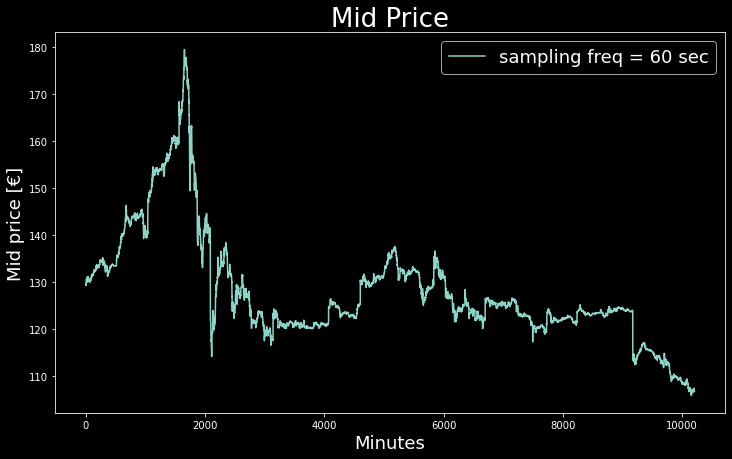

In [13]:
fig,ax = plt.subplots(1,1,figsize = (12,7))
plt.title("Mid Price", fontsize = 26)
plt.xlabel("Minutes", fontsize = 18)
plt.ylabel("Mid price [€]", fontsize = 18)
lenght = len(time_df)
x = np.arange(0, lenght, 60)//60
plt.plot(x, time_df["MidPrice"].iloc[::60],label = "sampling freq = 60 sec")
plt.legend(fontsize = 18)
plt.show()

Per vedere quanto è comune questa possibilità ho fatto un grafico a barre del volume di occupazione medio del LOB alle 10 migliori quote dell'ask e del bid price.

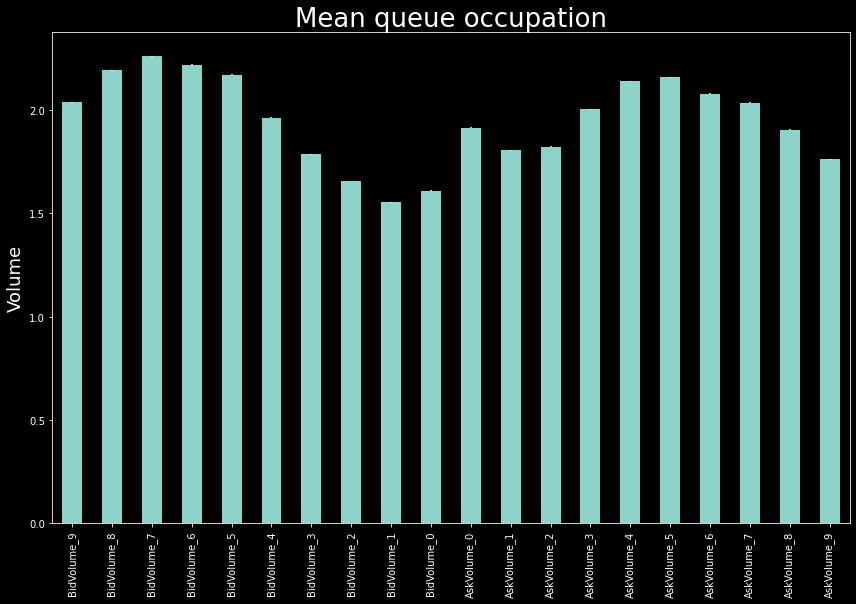

In [14]:
fig,ax = plt.subplots(1,1,figsize = (12,8.5), tight_layout = True)
lob_status = pd.concat([time_df.iloc[:,-6:0:-4], time_df.iloc[:,4:-2:4]], axis = 1)

lob_status.mean().plot.bar(yerr=lob_status.std() / np.sqrt(len(lob_status)),)
plt.title("Mean queue occupation", fontsize = 26)
plt.ylabel("Volume", fontsize = 18)
plt.savefig("../figures/mean_queue.jpeg", dpi = 300)
plt.show()

Dal grafico si può vedere che il volume medio di occupazione del LOB è molto basso.

Nel grafico a barre sono presenti anche gli standard error, ma questi sono molto piccoli, perciò non sono ben visibili.

Successivamente ho graficato la distanza media dal mid price per le 10 migliori quote dell'ask e del bid.

In [15]:
time_df.head()

,Datetime,BidPrice_0,BidVolume_0,AskPrice_0,AskVolume_0,BidPrice_1,BidVolume_1,AskPrice_1,AskVolume_1,BidPrice_2,...,BidVolume_8,AskPrice_8,AskVolume_8,BidPrice_9,BidVolume_9,AskPrice_9,AskVolume_9,MidPrice,Spread,Time
0,2021-10-01 07:00:01.289,129.0,1.0,130.2,1.0,128.54,1.0,131.5,2.0,128.51,...,1.0,0.0,0.0,125.5,1.0,0.0,0.0,129.6,1.2,25201.289
1,2021-10-01 07:00:01.289,129.0,1.0,130.2,1.0,128.54,1.0,131.5,2.0,128.51,...,1.0,0.0,0.0,125.5,1.0,0.0,0.0,129.6,1.2,25201.289
2,2021-10-01 07:00:01.289,129.0,1.0,130.2,1.0,128.54,1.0,131.5,2.0,128.51,...,1.0,0.0,0.0,125.5,1.0,0.0,0.0,129.6,1.2,25201.289
3,2021-10-01 07:00:01.289,129.0,1.0,130.2,1.0,128.54,1.0,131.5,2.0,128.51,...,1.0,0.0,0.0,125.5,1.0,0.0,0.0,129.6,1.2,25201.289
4,2021-10-01 07:00:01.289,129.0,1.0,130.2,1.0,128.54,1.0,131.5,2.0,128.51,...,1.0,0.0,0.0,125.5,1.0,0.0,0.0,129.6,1.2,25201.289


In [16]:
# create a dataframe with only the prices at the 10 best quotes of the ask and the bid
prices = pd.concat([time_df.iloc[:,-7:0:-4], time_df.iloc[:,3:-3:4]], axis= 1)
prices = prices*100
prices["MidPrice"] = (prices['AskPrice_0'] + prices["BidPrice_0"]) / 2

for column in prices:
    if column != "MidPrice":
        # calculate distance from mid price
        prices[column] = prices[[column, "MidPrice"]].diff(axis=1).drop(column, axis=1)
        # if there is no order at a price level set the distance to 0
        prices.loc[prices[column] == prices["MidPrice"], [column]] = 0

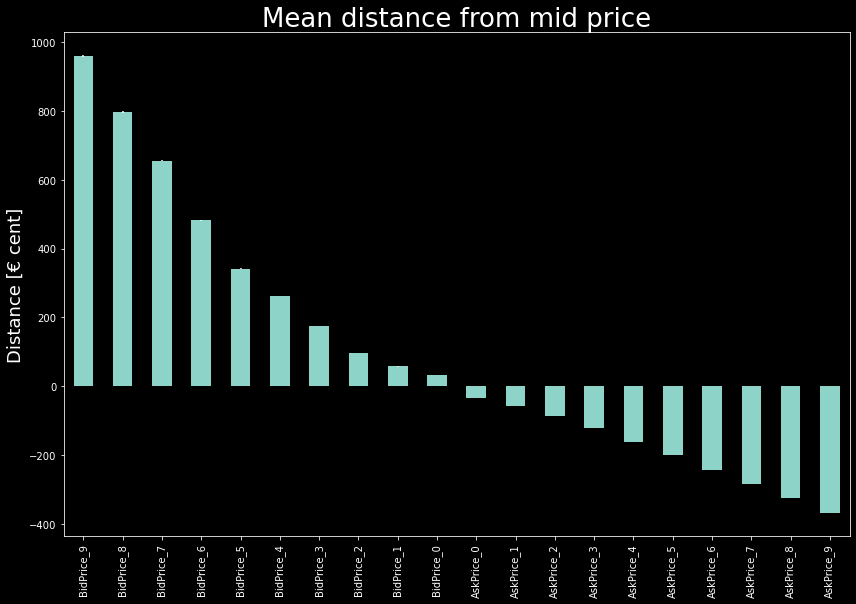

In [17]:
fig,ax = plt.subplots(1,1,figsize = (12,8.5), tight_layout = True)
prices.iloc[:,:-1].mean().plot.bar(yerr = prices.iloc[:,:-1].std() / np.sqrt(len(prices)))
plt.title("Mean distance from mid price", fontsize = 26)
plt.ylabel("Distance [€ cent]" ,fontsize= 18)
plt.savefig("../figures/distance.jpeg", dpi=300)

Nel grafico sono presenti gli standard error, ma essendo molto piccoli non risultano visibili.

# Distribuzione dello spread

In seguito ho fatto un istogramma dello spread con frequenza di campionamento al minuto in scala semilogaritmica.

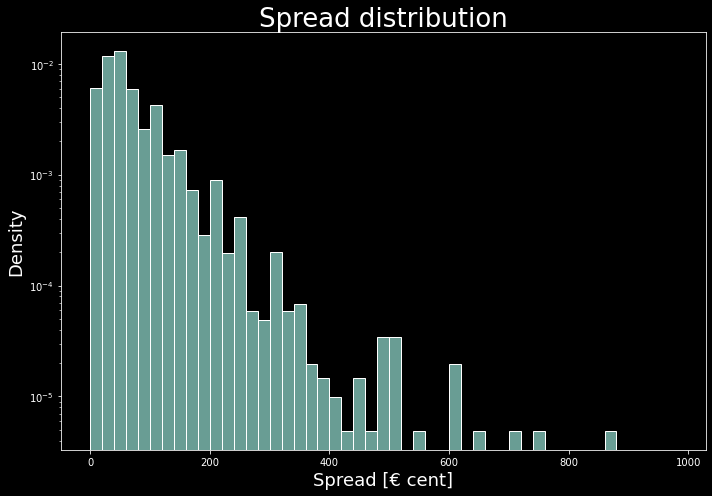

In [18]:
fig,ax = plt.subplots(1,1,figsize = (10,7), tight_layout = True)
# scale spread to € cent
time_df["Spread"] = time_df["Spread"] * 100
# plot histogram
sns.histplot(data=time_df.iloc[::60],x="Spread", bins = np.arange(0,1000,20), stat = "density")

plt.title("Spread distribution", fontsize=26)
plt.xlabel("Spread [€ cent]",fontsize=18)
plt.ylabel("Density",fontsize=18)
plt.yscale("log")
plt.savefig("../figures/spread_distribution.jpeg", dpi = 300)
plt.show()

In [19]:
mean_spr = time_df.iloc[::60]["Spread"].mean()
print(f"Mean spread {mean_spr:.0f} € cent")


Mean spread 66 € cent


# Distribuzione logaritmo dei ritorni

Dopodiché ho fatto un grafico della distribuzione dei ritorni con tempo di campionamento di un minuto in scala semilogaritmica.

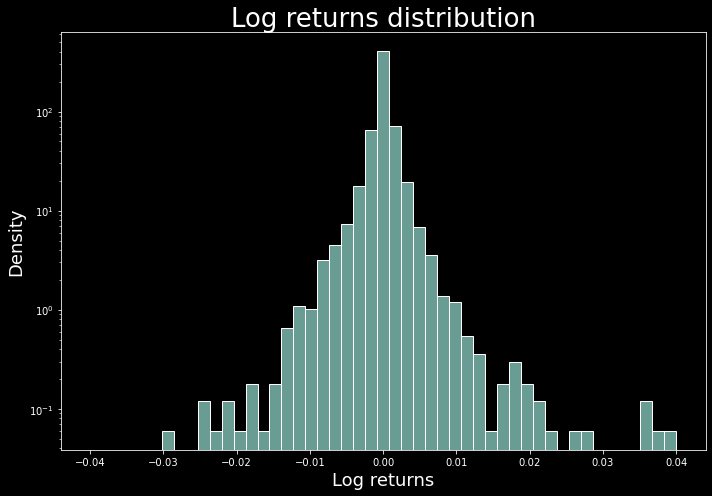

In [20]:
fig,ax = plt.subplots(1,1,figsize = (10,7), tight_layout = True)

mp = np.log(time_df["MidPrice"])
x = np.linspace(-0.04,0.04,50)

sns.histplot(data=mp[::60].diff(), bins = x, stat="density", 
             label="data")

mu_r  = mp.diff().mean()
std_r = mp.diff().std()

#plt.plot(x, scipy.stats.norm.pdf(x,mu_r,std_r), c="gold", label="gaussian")

plt.title("Log returns distribution",fontsize=26)
plt.ylabel("Density",fontsize=18)
plt.xlabel("Log returns",fontsize=18)
plt.yscale("log")
#plt.legend(fontsize=18)
plt.savefig("../figures/return_distribution.jpeg", dpi = 300)
plt.show()

Dalla figura si può vedere come la distribuzione dei ritorni abbia un comportamento molto leptocurtico.

# Signature plot

Infine ho realizzato il signature plot della volatilità realizzata:

$RV(\tau) = \sqrt{\sum_t (p_{(t+1)\tau} - p_{t\tau})^2}$

dove $p_t$ mi indica il prezzo medio al tempo t.

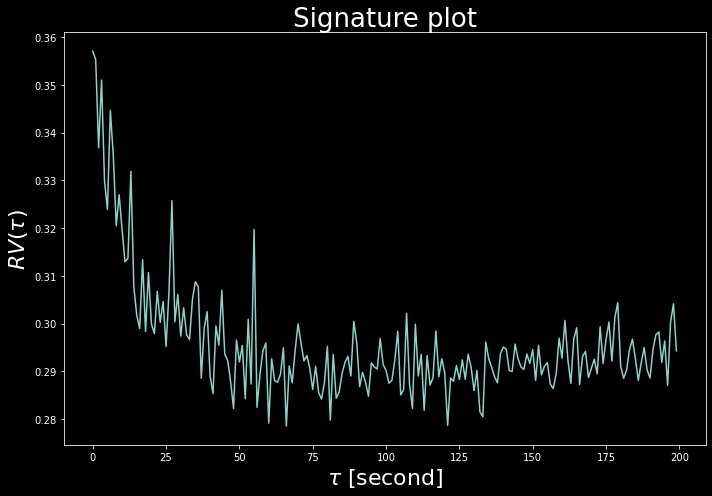

In [21]:
fig,ax = plt.subplots(1,1,figsize = (10,7), tight_layout = True)
x = np.arange(0,200)
plt.plot(x,compute_signature_plot(200, mp.to_numpy()))
plt.title("Signature plot", fontsize = 26)
plt.xlabel(r"$\tau$ [second]", fontsize = 22)
plt.ylabel(r"$RV(τ)$", fontsize = 22)
plt.savefig("../figures/signature_plot.jpeg", dpi=300)
plt.show()

# Autocorrelazione market orders

Nell'ultima parte di questo notebook ho analizzato l'autocorrelazione, i tempi di arrivo e la funzione di risposta dei market orders.

Per ricavare queste informazioni ho però bisogno del segno dei trades, che ho stimato dal mid price.

In [22]:
# import trade data
#create a list of all the files in the folder
DIR_1 = "../data/energia/trade_ottobre2021_nuovo/trade_ottobre2021/"
trade_files =os.listdir(DIR_1)
trade_files.sort()
lst_trade = []
for element in trade_files:
    # import data
    df = pd.read_csv(DIR_1 + element)

    df.drop(columns = ["Unnamed: 0"], inplace = True)

    # transform the column Datetime from string to datetime
    df["DateTime"]= pd.to_datetime(df["DateTime"])

    #delete trades befor 6:00 and after 17:00 
    df = df[df["DateTime"].dt.hour > 6]
    df = df[df["DateTime"].dt.hour < 16]
    lst_trade.append(df)

trade_df = pd.concat(lst_trade)
#trade_df.head()


In [59]:
clean_data = clean_data.loc[: ,["Datetime", "MidPrice", "Seconds", "Spread"]]

In [49]:
#Inferire segno dal mid price
trade_df = trade_df.loc[trade_df["DateTime"].dt.hour > 6]
trade_df = trade_df.loc[trade_df["DateTime"].dt.hour < 16]

trade_df["Seconds"] =  trade_df["DateTime"].dt.hour * 3600 + trade_df["DateTime"].dt.minute * 60 \
                        + trade_df["DateTime"].dt.second + trade_df["DateTime"].dt.microsecond * 1e-6 \
                        + trade_df["DateTime"].dt.day * 3600 * 24

# add sign of a trade and mid price before the arrival of a market order
trade_df["Sign"] = trade_df["Seconds"] * 0
trade_df["MidPrice"] = trade_df["Seconds"] * 0

# for each element in the trade dataframe 
for i in range(len(trade_df)):
    if i % 1000 == 0:
        print(i/100, "% done", end="\r")
    # find the mid price before th arrival of the market order
    date = trade_df["Seconds"].iat[i]
    trade_df["MidPrice"].iat[i] = clean_data[clean_data["Seconds"] < date]["MidPrice"].iat[-1]
    
    # infer the sign from the mid price 
    if clean_data[clean_data["Seconds"] < date]["MidPrice"].iat[-1] < trade_df["Price"].iat[i]:
        trade_df["Sign"].iat[i] = 1
    elif clean_data[clean_data["Seconds"] < date]["MidPrice"].iat[-1] > trade_df["Price"].iat[i]:
        trade_df["Sign"].iat[i] = -1
    else:
        trade_df["Sign"].iat[i] = np.random.choice([-1,1])
 



In [50]:
trade_df["Seconds"] =  trade_df["DateTime"].dt.hour * 3600 + trade_df["DateTime"].dt.minute * 60 \
                        + trade_df["DateTime"].dt.second + trade_df["DateTime"].dt.microsecond * 1e-6

In [51]:
trade_df.head()

,DateTime,Action,Volume,Price,AggressorAction,AggressorBroker,Seconds,Sign,MidPrice
21,2021-10-01 07:02:09+00:00,Insert,1.0,129.0,Sell,EEX,25329.000,-1.0,129.25
22,2021-10-01 07:02:09+00:00,Update,1.0,129.0,Sell,ICAP,25329.000,-1.0,129.25
23,2021-10-01 07:08:27+00:00,Insert,1.0,129.5,Sell,EEX,25707.000,-1.0,129.75
24,2021-10-01 07:09:19.896000+00:00,Update,2.0,130.0,Buy,GFI,25759.896,1.0,129.75
25,2021-10-01 07:09:25+00:00,Update,1.0,129.5,Sell,ICAP,25765.000,-1.0,129.85


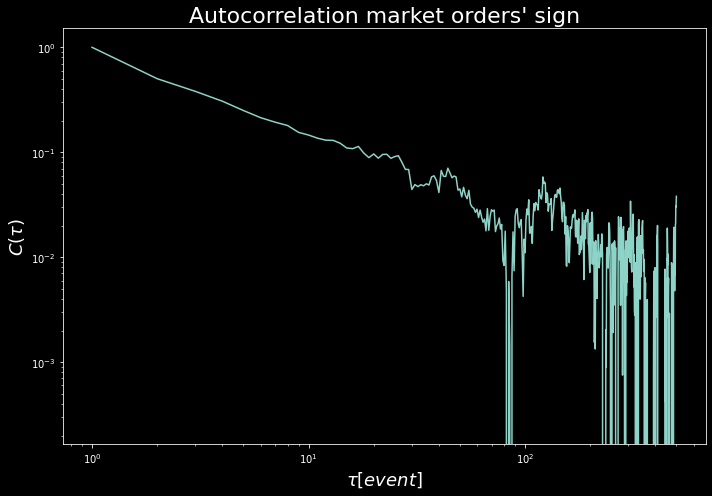

In [52]:
#@title Autocorrelazione Segno
tot = 500
corr = np.zeros(tot)
for i in range(tot):
  corr[i] = trade_df["Sign"].autocorr(i)

fig,ax = plt.subplots(1,1,figsize = (10,7), tight_layout = True)
xx = np.arange(1,tot+1)
plt.plot(xx,corr,)
plt.loglog()
plt.ylabel(r"$C(\tau)$", fontsize = 18)
plt.xlabel(r"$\tau [event]$", fontsize = 18)
plt.title("Autocorrelation market orders' sign", fontsize=22)
plt.savefig("../figures/autocorrelation.jpeg", dpi=300)
plt.show()

Si può osservare una memoria dell'ordine di 50 market orders.

Dopodiché ho provato a vedere se la differenza dei tempi di arrivo di market order vicini segue una distribuzione esponenziale attraverso un qq-plot.

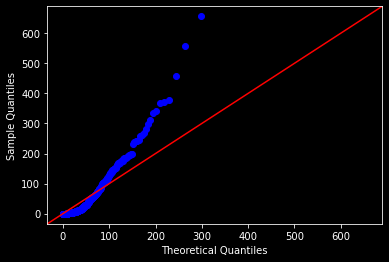

In [53]:
import statsmodels.api as sm
import scipy.stats


arrival_times = trade_df["Seconds"].diff().fillna(0).iloc[:400].to_numpy()

sm.qqplot(arrival_times, scipy.stats.expon, scale=arrival_times.mean(), line = "45")
plt.show()

Sia dal fatto che è presente una correlazione, sia dal qq plot possiamo concludere che il processo di arrivo dei market orders non è poissoniano.

# Impact market order

Definito il lag-dependent market impact (oppure funzione di risposta) come:

$R(\tau) = <ϵ_t  (m_{t+\tau} - m_t)>$

dove $ϵ_t$ mi indica il segno del market order al tempo t e $m_t$ mi indica il prezzo medio nell'istante immediatamente precedente all'arrivo del market order, ho cerceto di calcolare la funzione $R(\tau)$ per i dati energetici.

Dapprima ho cercato di verificare la relazione tra lo spread e la funzione di risposta R(1).

Dobbiamo infatti avere una relazione di proporzionalità diretta fra le due, perciò per ogni giorno di trading ho calcolato la funzione R(1) e lo spread medio.

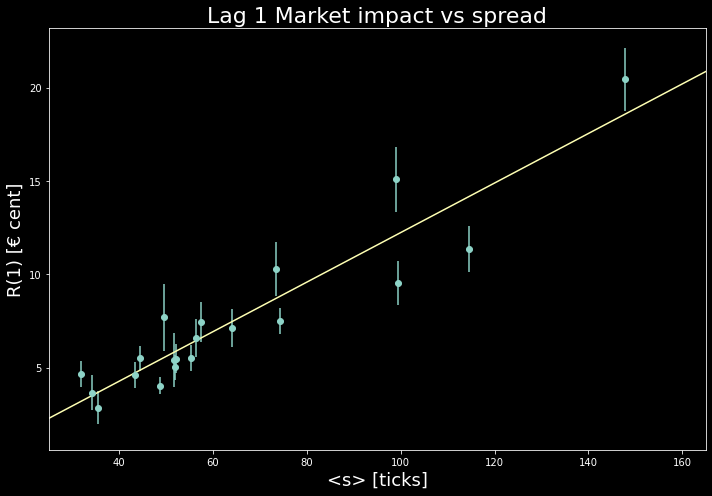

In [60]:
#@title R(1) vs spread
lag_impact = []
err_impact = []
spr = []
days = pd.unique(trade_df["DateTime"].dt.day)
# for each day
for element in days:
    if element != 27:
        # compute mean spread
        spr.append(clean_data[clean_data["Datetime"].dt.day == element]["Spread"].mean()*100)
        # compute R(1) and its error
        returns = trade_df[trade_df["DateTime"].dt.day == element]["MidPrice"].multiply(100).diff().dropna().to_numpy()
        sign = trade_df[trade_df["DateTime"].dt.day == element]["Sign"].iloc[:-1].to_numpy()
        lag_impact.append((returns*sign).mean())
        err_impact.append((returns*sign).std() / np.sqrt(len(returns)))

fig,ax = plt.subplots(1,1,figsize = (10,7), tight_layout = True)
# linear fit
m, q, err_m, err_q = find_param(spr, lag_impact)
xx = np.arange(20,170)
plt.xlim(25,165)
plt.errorbar(x = spr, y = lag_impact, yerr = err_impact, ls="", marker = "o")
plt.plot(xx, linear(xx, m, q))
plt.title("Lag 1 Market impact vs spread", fontsize = 22)
plt.xlabel("<s> [ticks]", fontsize = 18)
plt.ylabel("R(1) [€ cent]", fontsize = 18)
plt.savefig("../figures/lag1_MI.jpeg", dpi=300)
plt.show()

Dalla figura si può vedere che una retta fitta bene la relazione fra le due grandezze.

In [61]:
#@title Price impact in funzione del volume
price = np.zeros(trade_df.shape[0])

trade_df["Seconds"] =  trade_df["DateTime"].dt.hour * 3600 + trade_df["DateTime"].dt.minute * 60 \
                        + trade_df["DateTime"].dt.second + trade_df["DateTime"].dt.microsecond * 1e-6 \
                        + trade_df["DateTime"].dt.day * 3600 * 24

# compute price impact after 2 seconds
for i in range(trade_df.shape[0]):
    time = trade_df["Seconds"].iat[i] + 2
    price[i] = clean_data[clean_data["Seconds"] <= time]["MidPrice"].iat[-1] * 100



<ipython-input-62-aa9b15b1df61>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,2,3,4,5,"6+"])


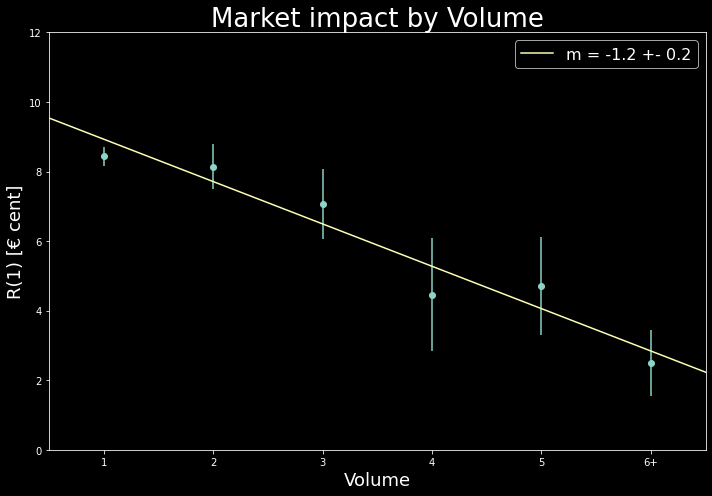

In [62]:
returns = price - trade_df["MidPrice"].multiply(100).to_numpy()
fig,ax = plt.subplots(1,1,figsize = (10,7), tight_layout=True)
sign = trade_df["Sign"].to_numpy()
volume = trade_df["Volume"].to_numpy()
gg = pd.DataFrame(sign,columns=["Sign"])
gg["Return"] = returns
gg["Volume"] = volume
gg.loc[gg["Volume"] > 5, ["Volume"]] = 6
gg["R"] = gg["Return"] * gg["Sign"]
aa = gg.groupby("Volume")["R"].mean()
gg.groupby("Volume")["R"].mean().plot(marker = "o", ls = "", yerr = gg.groupby("Volume")["R"].std() / np.sqrt(gg.groupby("Volume")["R"].count()), label="")
plt.xlim(0.5,6.5)
plt.ylim(0,12)
plt.title("Market impact by Volume", fontsize = 26)
plt.ylabel("R(1) [€ cent]", fontsize = 18)
plt.xlabel("Volume", fontsize = 18)

m, q, err_m, err_q = find_param(np.arange(1,7), aa)
plt.plot(np.arange(0,8), linear(np.arange(0,8), m, q), label=f"m = {m:.1f} +- {err_m:.1f}")


ax.set_xticklabels([0,1,2,3,4,5,"6+"])
plt.legend(fontsize = 16)
plt.savefig("../figures/impact_volume.jpeg", dpi= 300)
plt.show()

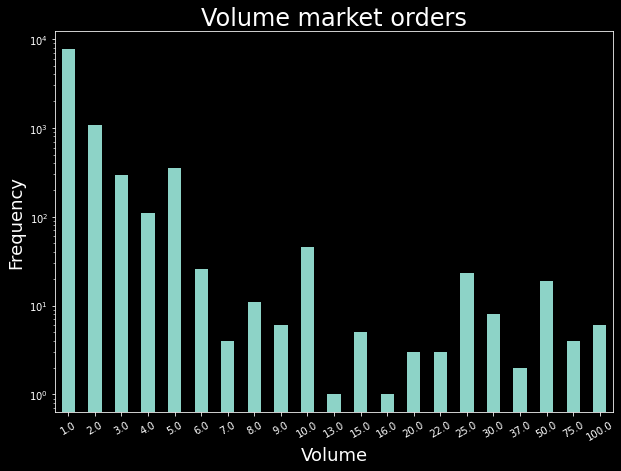

In [63]:
fig,ax = plt.subplots(1,1,figsize = (10,7))
trade_df["Volume"].value_counts().sort_index().plot.bar(rot=30)
plt.title("Volume market orders", fontsize= 24)
plt.ylabel("Frequency", fontsize = 18)
plt.xlabel("Volume", fontsize = 18)
plt.yscale("log")
plt.show()